In [ ]:
!pip install open3d

In [ ]:
import cv2
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
from torchvision import models
import torch

### Clone the SoccerNet Camera Calibration repository

In [ ]:
!git clone https://github.com/SoccerNet/sn-calibration

Cloning into 'sn-calibration'...
remote: Enumerating objects: 232, done.
remote: Counting objects: 100% (82/82), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 232 (delta 60), reused 53 (delta 48), pack-reused 150 (from 1)
Receiving objects: 100% (232/232), 2.68 MiB | 27.44 MiB/s, done.
Resolving deltas: 100% (131/131), done.


In [ ]:
%cd sn-calibration

/content/sn-calibration


In [ ]:
%cd src/

/content/sn-calibration/src


In [ ]:
%ls

baseline_cameras.py  detect_extremities.py  evaluate_extremities.py
camera.py            evalai_camera.py       soccerpitch.py
dataloader.py        evaluate_camera.py


NOTE:
Download weights from https://github.com/SoccerNet/sn-calibration (do f1 "drive"to find link) and move inside resources

Go into src/detect_extremities.py (double clic to open editor on colab) and remove src from "from src.soccerpitch import SoccerPitch" and save.

In [ ]:
from detect_extremities import SegmentationNetwork

In [ ]:
seg_net = SegmentationNetwork(
    "../resources/soccer_pitch_segmentation.pth",
    "../resources/mean.npy",
    "../resources/std.npy"
)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 201MB/s]


In [ ]:
from soccerpitch import SoccerPitch

lines_palette = [0, 0, 0]
for line_class in SoccerPitch.lines_classes:
  lines_palette.extend(SoccerPitch.palette[line_class])

NOTE: Move img1 and img2 to sn-calibration/images.

# Image 1

(540, 960, 3)


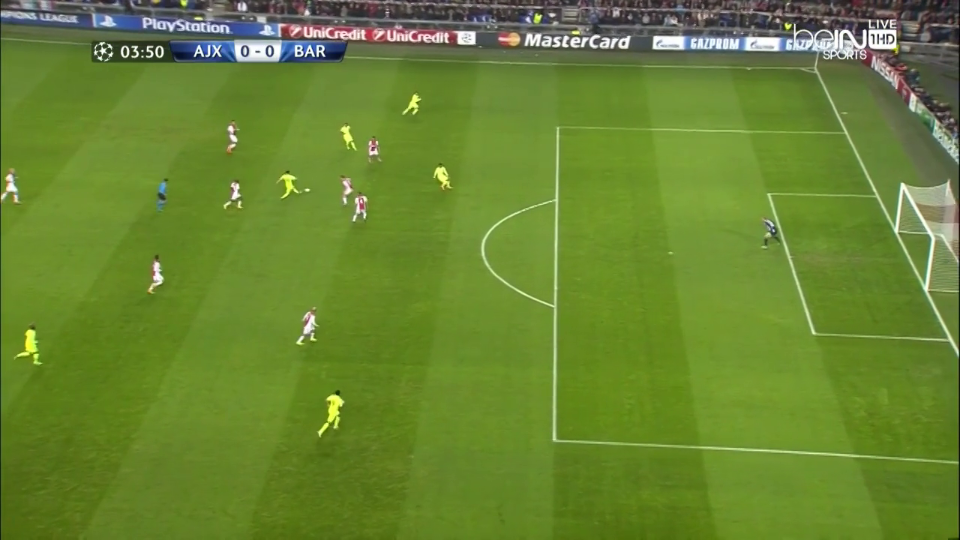

In [ ]:
from PIL import Image
import cv2

image = cv2.imread("../images/0_0.png")
image = cv2.resize(image, (960, 540))
print(image.shape)
rgbimage = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
pil_image = Image.fromarray(rgbimage)
pil_image

### Regulatory pitch

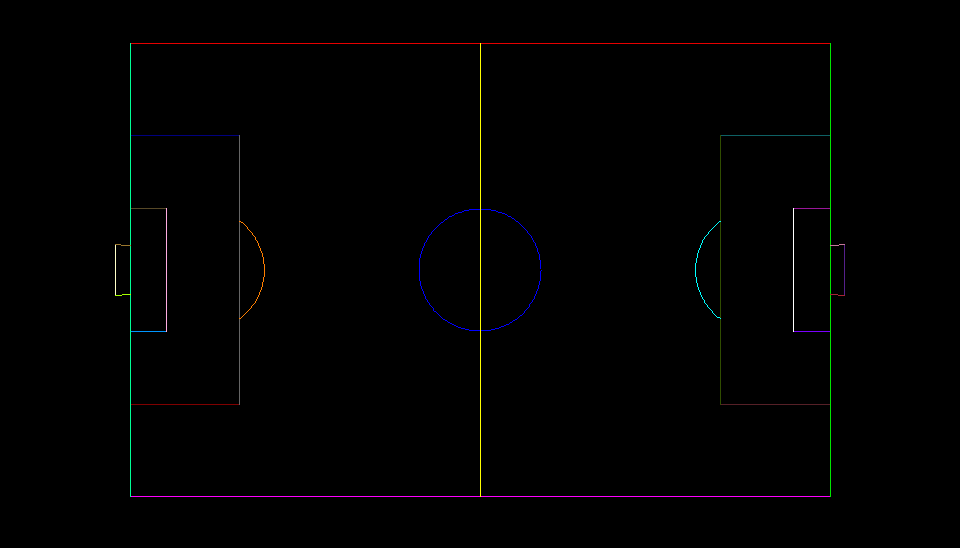

In [ ]:
from camera import Camera

black_img = np.zeros((548, 960, 3), dtype=np.uint8)

camera = Camera()
camera.xfocal_length = 400
camera.yfocal_length = 400
camera.position = [0, 0, -60]
camera.draw_colorful_pitch(black_img, SoccerPitch.palette)
rgb_model = cv2.cvtColor(black_img, cv2.COLOR_BGR2RGB)
pitch_model = Image.fromarray(rgb_model)
pitch_model

<ipython-input-12-fcd3c44d6ee4>:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y1 = int(((min_x - px) * vy / vx) + py)
<ipython-input-12-fcd3c44d6ee4>:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y2 = int(((max_x - px) * vy / vx) + py)
<ipython-input-12-fcd3c44d6ee4>:37: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x1 = int(((min_y - py) * vx / vy) + px)
<ipython-input-12-fcd3c44d6ee4>:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scala

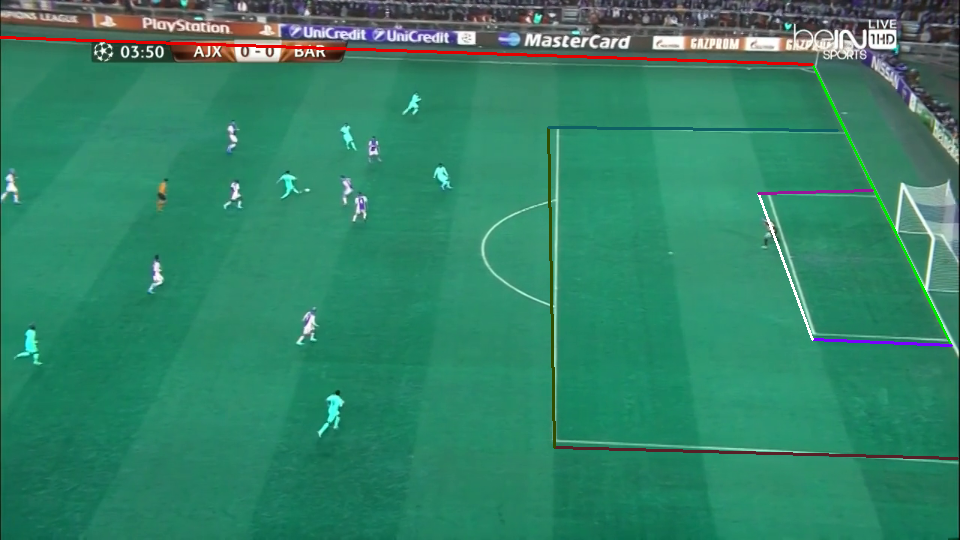

In [ ]:
import cv2
import numpy as np
from PIL import Image

# Step 1: Get raw segmentation output
seg_mask = seg_net.analyse_image(image)
pitch = SoccerPitch()

# Step 2: Create empty mask for cleaned results
cleaned_mask = np.zeros_like(seg_mask, dtype=np.uint8)
line_data = []

# Step 3: Extract lines from the segmentation mask
for class_idx, class_name in enumerate(SoccerPitch.lines_classes):
    if "post" in class_name or "crossbar" in class_name or "Circle" in class_name:
        continue

    class_mask = (seg_mask == class_idx + 1).astype(np.uint8)
    color = SoccerPitch.palette[class_name]

    kernel = np.ones((5, 5), np.uint8)
    class_mask = cv2.morphologyEx(class_mask, cv2.MORPH_OPEN, kernel)

    contours, _ = cv2.findContours(class_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        [vx, vy, px, py] = cv2.fitLine(largest_contour, cv2.DIST_L2, 0, 0.01, 0.01)
        points = largest_contour[:, 0, :]

        if abs(vx) > abs(vy):
            min_x, max_x = np.min(points[:, 0]), np.max(points[:, 0])
            y1 = int(((min_x - px) * vy / vx) + py)
            y2 = int(((max_x - px) * vy / vx) + py)
            pt1, pt2 = (min_x, y1), (max_x, y2)
        else:
            min_y, max_y = np.min(points[:, 1]), np.max(points[:, 1])
            x1 = int(((min_y - py) * vx / vy) + px)
            x2 = int(((max_y - py) * vx / vy) + px)
            pt1, pt2 = (x1, min_y), (x2, max_y)

        line_data.append({
            'class_name': class_name,
            'class_idx': class_idx + 1,
            'pt1': pt1,
            'pt2': pt2,
        })

# Step 4: Merge close endpoints
threshold = 20
def close(p1, p2, t=threshold):
    return np.linalg.norm(np.array(p1) - np.array(p2)) < t

for i in range(len(line_data)):
    for j in range(i + 1, len(line_data)):
        for key_i, key_j in [('pt1', 'pt1'), ('pt1', 'pt2'), ('pt2', 'pt1'), ('pt2', 'pt2')]:
            p1 = line_data[i][key_i]
            p2 = line_data[j][key_j]
            if close(p1, p2):
                avg = tuple(np.mean([p1, p2], axis=0).astype(int))
                line_data[i][key_i] = avg
                line_data[j][key_j] = avg

# Step 5: Draw lines and store homogeneous line equations
extremities_image = image.copy()
height, width = image.shape[:2]

line_matches = []
for line in line_data:
    label = line['class_name']
    color = pitch.palette.get(label, (255, 255, 255))  # fallback color if missing

    # Scale from segmentation coords (360x640) to actual image size
    pt1 = (
        int(line['pt1'][0] * (width - 1) / 640.),
        int(line['pt1'][1] * (height - 1) / 360.)
    )
    pt2 = (
        int(line['pt2'][0] * (width - 1) / 640.),
        int(line['pt2'][1] * (height - 1) / 360.)
    )

    # Draw the line
    cv2.line(extremities_image, pt1, pt2, color, 2)

    # Get homogeneous line
    img_line = np.cross([pt1[0], pt1[1], 1], [pt2[0], pt2[1], 1])
    if not np.any(np.isnan(img_line)) and not np.any(np.isinf(img_line)):
        pitch_line = pitch.get_2d_homogeneous_line(label)
        if pitch_line is not None:
            line_matches.append((pitch_line, img_line))

# Step 6: Convert to PIL image for display
extremities_pil = Image.fromarray(extremities_image)
extremities_pil

Compute homography from 3d pitch to 2D image.

In [ ]:
def estimate_homography_from_line_correspondences(lines, T1=np.eye(3), T2=np.eye(3)):
    """
    Given lines correspondences, computes the homography that maps best the two set of lines.
    :param lines: list of pair of 2D lines matches.
    :param T1: Similarity transform to normalize the elements of the source reference system
    :param T2: Similarity transform to normalize the elements of the target reference system
    :return: boolean to indicate success or failure of the estimation, homography
    """
    homography = np.eye(3)
    A = np.zeros((len(lines) * 2, 9))

    for i, line_pair in enumerate(lines):
        src_line = np.transpose(np.linalg.inv(T1)) @ line_pair[0]
        target_line = np.transpose(np.linalg.inv(T2)) @ line_pair[1]
        u = src_line[0]
        v = src_line[1]
        w = src_line[2]

        x = target_line[0]
        y = target_line[1]
        z = target_line[2]

        A[2 * i, 0] = 0
        A[2 * i, 1] = x * w
        A[2 * i, 2] = -x * v
        A[2 * i, 3] = 0
        A[2 * i, 4] = y * w
        A[2 * i, 5] = -v * y
        A[2 * i, 6] = 0
        A[2 * i, 7] = z * w
        A[2 * i, 8] = -v * z

        A[2 * i + 1, 0] = x * w
        A[2 * i + 1, 1] = 0
        A[2 * i + 1, 2] = -x * u
        A[2 * i + 1, 3] = y * w
        A[2 * i + 1, 4] = 0
        A[2 * i + 1, 5] = -u * y
        A[2 * i + 1, 6] = z * w
        A[2 * i + 1, 7] = 0
        A[2 * i + 1, 8] = -u * z

    try:
        u, s, vh = np.linalg.svd(A)
    except np.linalg.LinAlgError:
        return False, homography
    v = np.eye(3)
    has_positive_singular_value = False
    for i in range(s.shape[0] - 1, -2, -1):
        v = np.reshape(vh[i], (3, 3))

        if s[i] > 0:
            has_positive_singular_value = True
            break

    if not has_positive_singular_value:
        return False, homography

    homography = np.reshape(v, (3, 3))
    homography = np.linalg.inv(T2) @ homography @ T1
    homography /= homography[2, 2]

    return True, homography

success, homography1 = estimate_homography_from_line_correspondences(line_matches)
homography1

array([[ 2.29720160e+01, -5.58531583e+00, -2.62915112e+02],
       [ 7.90879320e-01,  5.26684438e+00,  2.26914875e+02],
       [ 7.30656971e-04, -1.04912823e-02,  1.00000000e+00]])

Again remove src from the file.

Fit the regulatory pitch into the image using the homography.

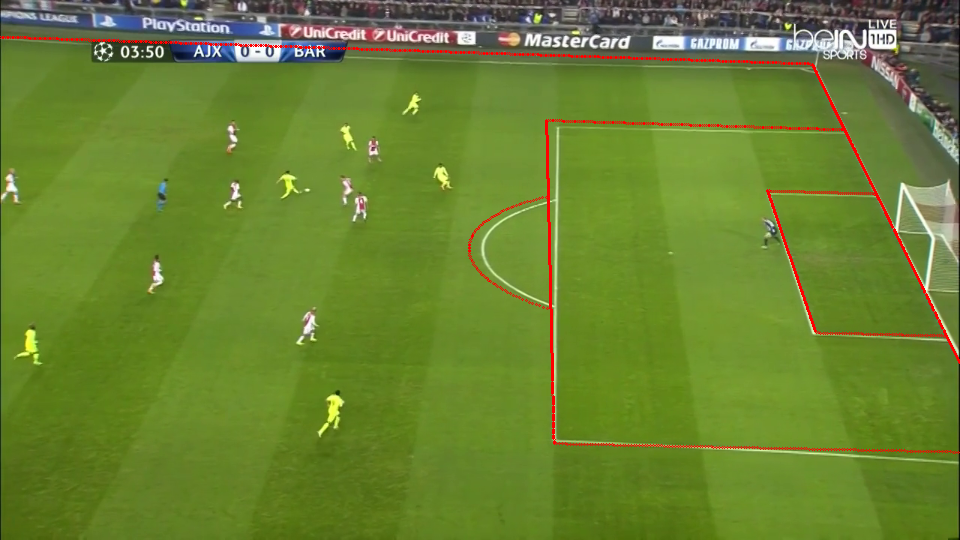

In [ ]:
from baseline_cameras import draw_pitch_homography

cv_image = draw_pitch_homography(rgbimage, homography1)
homography_pil = Image.fromarray(cv_image)
homography_pil


### Compute intrinsic and extrinsic parameters from homography

Compute K

In [ ]:
def estimate_calibration_matrix_from_plane_homography(cam, homography):
        """
        This method initializes the calibration matrix from the homography between the world plane of the pitch
        and the image. It is based on the extraction of the calibration matrix from the homography (Algorithm 8.2 of
        Multiple View Geometry in computer vision, p225). The extraction is sensitive to noise, which is why we keep the
        principal point in the middle of the image rather than using the one extracted by this method.
        :param homography: homography between the world plane of the pitch and the image
        """
        H = np.reshape(homography, (9,))
        A = np.zeros((5, 6))
        A[0, 1] = 1.
        A[1, 0] = 1.
        A[1, 2] = -1.
        A[2, 3] = cam.principal_point[1] / cam.principal_point[0]
        A[2, 4] = -1.0
        A[3, 0] = H[0] * H[1]
        A[3, 1] = H[0] * H[4] + H[1] * H[3]
        A[3, 2] = H[3] * H[4]
        A[3, 3] = H[0] * H[7] + H[1] * H[6]
        A[3, 4] = H[3] * H[7] + H[4] * H[6]
        A[3, 5] = H[6] * H[7]
        A[4, 0] = H[0] * H[0] - H[1] * H[1]
        A[4, 1] = 2 * H[0] * H[3] - 2 * H[1] * H[4]
        A[4, 2] = H[3] * H[3] - H[4] * H[4]
        A[4, 3] = 2 * H[0] * H[6] - 2 * H[1] * H[7]
        A[4, 4] = 2 * H[3] * H[6] - 2 * H[4] * H[7]
        A[4, 5] = H[6] * H[6] - H[7] * H[7]

        u, s, vh = np.linalg.svd(A)
        w = vh[-1]
        W = np.zeros((3, 3))
        W[0, 0] = w[0] / w[5]
        W[0, 1] = w[1] / w[5]
        W[0, 2] = w[3] / w[5]
        W[1, 0] = w[1] / w[5]
        W[1, 1] = w[2] / w[5]
        W[1, 2] = w[4] / w[5]
        W[2, 0] = w[3] / w[5]
        W[2, 1] = w[4] / w[5]
        W[2, 2] = w[5] / w[5]

        try:
            Ktinv = np.linalg.cholesky(W)
        except np.linalg.LinAlgError:
            K = np.eye(3)
            return False, K

        K = np.linalg.inv(np.transpose(Ktinv))
        K /= K[2, 2]

        cam.xfocal_length = K[0, 0]
        cam.yfocal_length = K[1, 1]
        # the principal point estimated by this method is very noisy, better keep it in the center of the image
        #cam.principal_point = (cam.image_width / 2, cam.image_height / 2)
        cam.principal_point = (K[0,2], K[1,2])
        cam.calibration = np.array([
            [cam.xfocal_length, 0, cam.principal_point[0]],
            [0, cam.yfocal_length, cam.principal_point[1]],
            [0, 0, 1]
        ], dtype='float')
        return True, K

Compute R and t

In [ ]:
def from_homography(cam, homography):
        """
        This method initializes the essential camera parameters from the homography between the world plane of the pitch
        and the image. It is based on the extraction of the calibration matrix from the homography (Algorithm 8.2 of
        Multiple View Geometry in computer vision, p225), then using the relation between the camera parameters and the
        same homography, we extract rough rotation and position estimates (Example 8.1 of Multiple View Geometry in
        computer vision, p196).
        :param homography: The homography that captures the transformation between the 3D flat model of the soccer pitch
         and its image.
        """
        success, _ = estimate_calibration_matrix_from_plane_homography(cam, homography)
        if not success:
            return False

        hprim = np.linalg.inv(cam.calibration) @ homography
        lambda1 = 1 / np.linalg.norm(hprim[:, 0])
        lambda2 = 1 / np.linalg.norm(hprim[:, 1])
        lambda3 = np.sqrt(lambda1 * lambda2)

        r0 = hprim[:, 0] * lambda1
        r1 = hprim[:, 1] * lambda2
        r2 = np.cross(r0, r1)

        R = np.column_stack((r0, r1, r2))
        u, s, vh = np.linalg.svd(R)
        R = u @ vh
        if np.linalg.det(R) < 0:
            u[:, 2] *= -1
            R = u @ vh
        cam.rotation = R
        t = hprim[:, 2] * lambda3
        cam.position = - np.transpose(R) @ t
        return True

In [ ]:
cam1 = Camera(960, 540)
success = from_homography(cam1, homography1)
cam1.to_json_parameters()

{'pan_degrees': np.float64(3.9838860608708706),
 'tilt_degrees': np.float64(66.53010591373204),
 'roll_degrees': np.float64(-2.934611483800422),
 'position_meters': [34.41659243068911,
  84.10978321634066,
  -31.257200884252327],
 'x_focal_length': np.float64(1967.5198786478302),
 'y_focal_length': np.float64(1967.5198786477322),
 'principal_point': [np.float64(637.8304394641893),
  np.float64(358.77962219857085)],
 'radial_distortion': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'tangential_distortion': [0.0, 0.0],
 'thin_prism_distortion': [0.0, 0.0, 0.0, 0.0]}

Using the estimated camera position and parameters, view the 3D space from there.

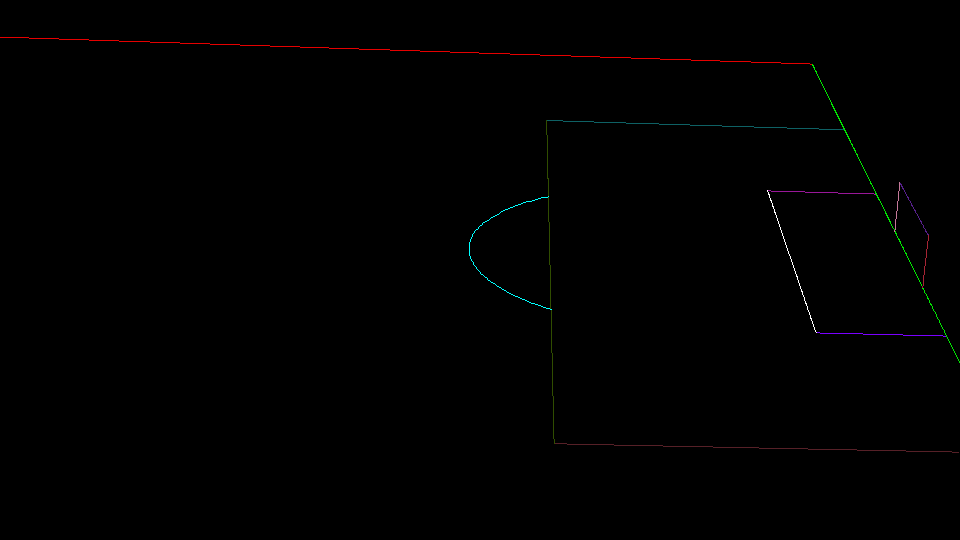

In [ ]:
black_img = np.zeros((540, 960, 3), dtype=np.uint8)
cam1.draw_colorful_pitch(black_img, SoccerPitch.palette)
rgb_model = cv2.cvtColor(black_img, cv2.COLOR_BGR2RGB)
pitch_model = Image.fromarray(rgb_model)
pitch_model

In [ ]:
image = cv2.imread("../images/3.png")
image = cv2.resize(image, (960, 540))
rgbimage = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

Construct the projection matrix from the computed parameters.

In [ ]:
def pan_tilt_roll_to_orientation(pan, tilt, roll):
    """
    Conversion from euler angles to orientation matrix.
    :param pan:
    :param tilt:
    :param roll:
    :return: orientation matrix
    """
    Rpan = np.array([
        [np.cos(pan), -np.sin(pan), 0],
        [np.sin(pan), np.cos(pan), 0],
        [0, 0, 1]])
    Rroll = np.array([
        [np.cos(roll), -np.sin(roll), 0],
        [np.sin(roll), np.cos(roll), 0],
        [0, 0, 1]])
    Rtilt = np.array([
        [1, 0, 0],
        [0, np.cos(tilt), -np.sin(tilt)],
        [0, np.sin(tilt), np.cos(tilt)]])
    rotMat = np.dot(Rpan, np.dot(Rtilt, Rroll))
    return rotMat

In [ ]:
import numpy as np
from scipy.spatial.transform import Rotation as R

def build_projection_matrix(params):
    fx = params['x_focal_length']
    fy = params['y_focal_length']
    cx, cy = params['principal_point']
    pan = np.radians(params['pan_degrees'])
    tilt = np.radians(params['tilt_degrees'])
    roll = np.radians(params['roll_degrees'])
    C = np.array(params['position_meters'])

    K = np.array([
        [fx,  0, cx],
        [ 0, fy, cy],
        [ 0,  0,  1]
    ])

    R_matrix = pan_tilt_roll_to_orientation(pan, tilt, roll).T
    t = -R_matrix @ C.reshape((3, 1))
    Rt = np.hstack((R_matrix, t))

    P = K @ Rt
    return P

P1 = build_projection_matrix(cam1.to_json_parameters())
print(P1)

[[ 2.00362661e+03 -4.87153039e+02  1.61630702e+02 -2.29315404e+04]
 [ 6.89807481e+01  4.59375857e+02  1.94526933e+03  1.97915882e+04]
 [ 6.37281355e-02 -9.15053006e-01  3.98267147e-01  8.72203209e+01]]


Project the regulatory pitch in the image using the projection matrix.

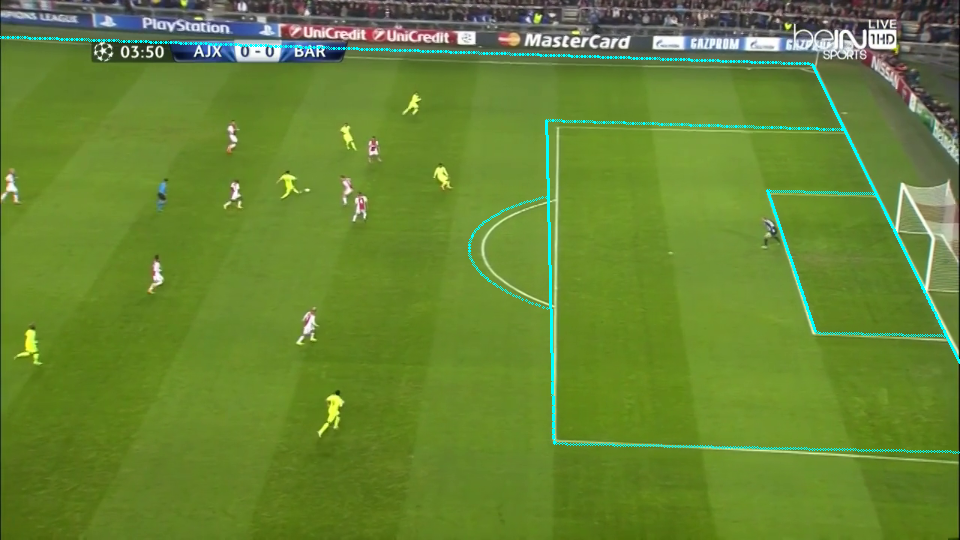

In [ ]:
def draw_pitch_projection_matrix(image, projection_matrix):
    """
    Draws points along the soccer pitch using a full 3x4 camera projection matrix M (P = K[R|t]).
    This function assumes that the pitch lies on the plane z=0 in world coordinates.

    :param image: the image to draw on
    :param projection_matrix: 3x4 camera projection matrix
    :return: modified image
    """
    field = SoccerPitch()
    polylines = field.sample_field_points()

    for line in polylines.values():
        for point in line:
            # We assume the pitch is at z = 0, so use only x, y
            if point[2] == 0.:
                X = np.array([point[0], point[1], 0., 1.])  # homogeneous 3D point with z = 0
                projected = X @ projection_matrix.T
                if projected[2] == 0.:
                    continue
                projected /= projected[2]
                x_img, y_img = projected[0], projected[1]                # Make sure it's in bounds
                if 0 <= x_img < image.shape[1] and 0 <= y_img < image.shape[0]:
                    cv2.circle(image, (int(x_img), int(y_img)), 1, (0, 255, 255), 1)

    return image


cv_image = draw_pitch_projection_matrix(rgbimage, P1)
homography_pil = Image.fromarray(cv_image)
homography_pil

# IMAGE 2

Repeat the process for the second view.

(540, 960, 3)


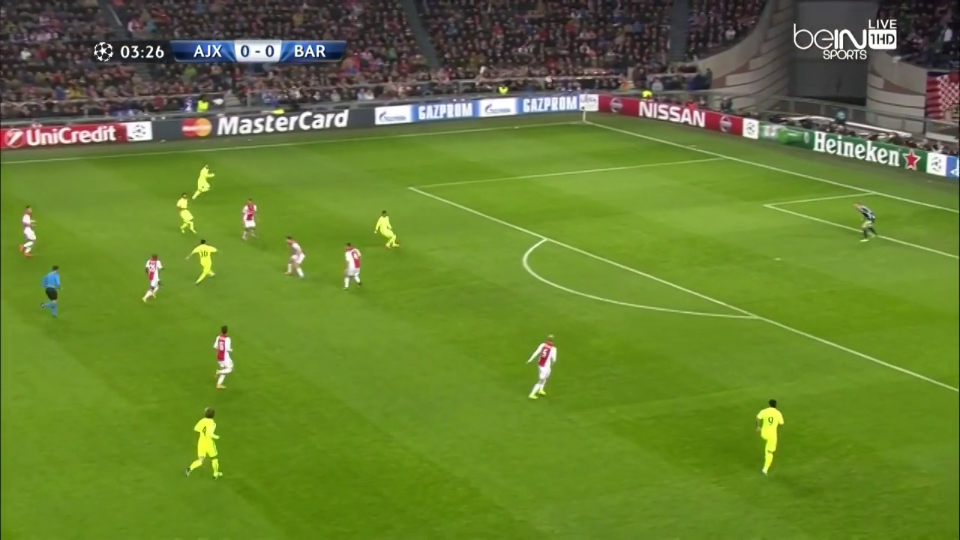

In [ ]:
from PIL import Image
import cv2

image = cv2.imread("../images/0.png")
image = cv2.resize(image, (960, 540))
print(image.shape)
rgbimage = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
pil_image = Image.fromarray(rgbimage)
pil_image

Raw segmentation

Cleaned Segmentation

<ipython-input-23-322fbf1974ab>:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y1 = int(((min_x - px) * vy / vx) + py)
<ipython-input-23-322fbf1974ab>:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y2 = int(((max_x - px) * vy / vx) + py)


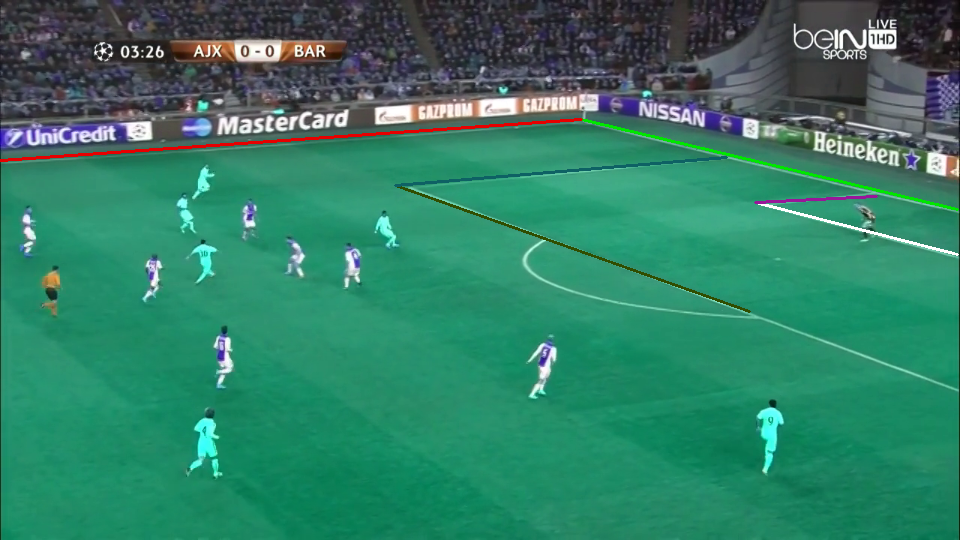

In [ ]:
import cv2
import numpy as np
from PIL import Image

# Step 1: Get raw segmentation output
seg_mask = seg_net.analyse_image(image)
pitch = SoccerPitch()

# Step 2: Create empty mask for cleaned results
cleaned_mask = np.zeros_like(seg_mask, dtype=np.uint8)
line_data = []

# Step 3: Extract lines from the segmentation mask
for class_idx, class_name in enumerate(SoccerPitch.lines_classes):
    if "post" in class_name or "crossbar" in class_name or "Circle" in class_name:
        continue

    class_mask = (seg_mask == class_idx + 1).astype(np.uint8)
    color = SoccerPitch.palette[class_name]

    kernel = np.ones((5, 5), np.uint8)
    class_mask = cv2.morphologyEx(class_mask, cv2.MORPH_OPEN, kernel)

    contours, _ = cv2.findContours(class_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        [vx, vy, px, py] = cv2.fitLine(largest_contour, cv2.DIST_L2, 0, 0.01, 0.01)
        points = largest_contour[:, 0, :]

        if abs(vx) > abs(vy):
            min_x, max_x = np.min(points[:, 0]), np.max(points[:, 0])
            y1 = int(((min_x - px) * vy / vx) + py)
            y2 = int(((max_x - px) * vy / vx) + py)
            pt1, pt2 = (min_x, y1), (max_x, y2)
        else:
            min_y, max_y = np.min(points[:, 1]), np.max(points[:, 1])
            x1 = int(((min_y - py) * vx / vy) + px)
            x2 = int(((max_y - py) * vx / vy) + px)
            pt1, pt2 = (x1, min_y), (x2, max_y)

        line_data.append({
            'class_name': class_name,
            'class_idx': class_idx + 1,
            'pt1': pt1,
            'pt2': pt2,
        })

# Step 4: Merge close endpoints
threshold = 20
def close(p1, p2, t=threshold):
    return np.linalg.norm(np.array(p1) - np.array(p2)) < t

for i in range(len(line_data)):
    for j in range(i + 1, len(line_data)):
        for key_i, key_j in [('pt1', 'pt1'), ('pt1', 'pt2'), ('pt2', 'pt1'), ('pt2', 'pt2')]:
            p1 = line_data[i][key_i]
            p2 = line_data[j][key_j]
            if close(p1, p2):
                avg = tuple(np.mean([p1, p2], axis=0).astype(int))
                line_data[i][key_i] = avg
                line_data[j][key_j] = avg

# Step 5: Draw lines and store homogeneous line equations
extremities_image = image.copy()
height, width = image.shape[:2]

line_matches = []
for line in line_data:
    label = line['class_name']
    color = pitch.palette.get(label, (255, 255, 255))  # fallback color if missing

    # Scale from segmentation coords (360x640) to actual image size
    pt1 = (
        int(line['pt1'][0] * (width - 1) / 640.),
        int(line['pt1'][1] * (height - 1) / 360.)
    )
    pt2 = (
        int(line['pt2'][0] * (width - 1) / 640.),
        int(line['pt2'][1] * (height - 1) / 360.)
    )

    # Draw the line
    cv2.line(extremities_image, pt1, pt2, color, 2)

    # Get homogeneous line
    img_line = np.cross([pt1[0], pt1[1], 1], [pt2[0], pt2[1], 1])
    if not np.any(np.isnan(img_line)) and not np.any(np.isinf(img_line)):
        pitch_line = pitch.get_2d_homogeneous_line(label)
        if pitch_line is not None:
            line_matches.append((pitch_line, img_line))

# Step 6: Convert to PIL image for display
extremities_pil = Image.fromarray(extremities_image)
extremities_pil



### Get homography 3D pitch to 2D image

In [ ]:
def estimate_homography_from_line_correspondences(lines, T1=np.eye(3), T2=np.eye(3)):
    """
    Given lines correspondences, computes the homography that maps best the two set of lines.
    :param lines: list of pair of 2D lines matches.
    :param T1: Similarity transform to normalize the elements of the source reference system
    :param T2: Similarity transform to normalize the elements of the target reference system
    :return: boolean to indicate success or failure of the estimation, homography
    """
    homography = np.eye(3)
    A = np.zeros((len(lines) * 2, 9))

    for i, line_pair in enumerate(lines):
        src_line = np.transpose(np.linalg.inv(T1)) @ line_pair[0]
        target_line = np.transpose(np.linalg.inv(T2)) @ line_pair[1]
        u = src_line[0]
        v = src_line[1]
        w = src_line[2]

        x = target_line[0]
        y = target_line[1]
        z = target_line[2]

        A[2 * i, 0] = 0
        A[2 * i, 1] = x * w
        A[2 * i, 2] = -x * v
        A[2 * i, 3] = 0
        A[2 * i, 4] = y * w
        A[2 * i, 5] = -v * y
        A[2 * i, 6] = 0
        A[2 * i, 7] = z * w
        A[2 * i, 8] = -v * z

        A[2 * i + 1, 0] = x * w
        A[2 * i + 1, 1] = 0
        A[2 * i + 1, 2] = -x * u
        A[2 * i + 1, 3] = y * w
        A[2 * i + 1, 4] = 0
        A[2 * i + 1, 5] = -u * y
        A[2 * i + 1, 6] = z * w
        A[2 * i + 1, 7] = 0
        A[2 * i + 1, 8] = -u * z

    try:
        u, s, vh = np.linalg.svd(A)
    except np.linalg.LinAlgError:
        return False, homography
    v = np.eye(3)
    has_positive_singular_value = False
    for i in range(s.shape[0] - 1, -2, -1):
        v = np.reshape(vh[i], (3, 3))

        if s[i] > 0:
            has_positive_singular_value = True
            break

    if not has_positive_singular_value:
        return False, homography

    homography = np.reshape(v, (3, 3))
    homography = np.linalg.inv(T2) @ homography @ T1
    homography /= homography[2, 2]

    return True, homography

success, homography2 = estimate_homography_from_line_correspondences(line_matches)
homography2

array([[ 5.47493642e+01,  1.06865901e+01, -9.78563337e+02],
       [-8.56252049e-01,  2.93932062e+00,  4.58874095e+02],
       [ 1.87882857e-02, -1.91576666e-02,  1.00000000e+00]])

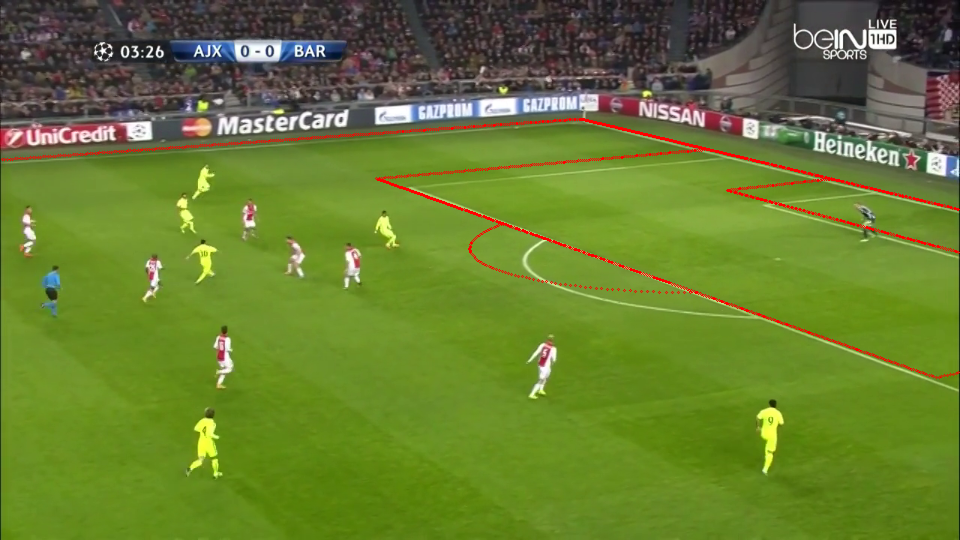

In [ ]:
from baseline_cameras import draw_pitch_homography

cv_image = draw_pitch_homography(rgbimage, homography2)
homography_pil = Image.fromarray(cv_image)
homography_pil

### Get projection matrix (K, R, and t)

Compute K

In [ ]:
def estimate_calibration_matrix_from_plane_homography(cam, homography):
        """
        This method initializes the calibration matrix from the homography between the world plane of the pitch
        and the image. It is based on the extraction of the calibration matrix from the homography (Algorithm 8.2 of
        Multiple View Geometry in computer vision, p225). The extraction is sensitive to noise, which is why we keep the
        principal point in the middle of the image rather than using the one extracted by this method.
        :param homography: homography between the world plane of the pitch and the image
        """
        H = np.reshape(homography, (9,))
        A = np.zeros((5, 6))
        A[0, 1] = 1.
        A[1, 0] = 1.
        A[1, 2] = -1.
        A[2, 3] = cam.principal_point[1] / cam.principal_point[0]
        A[2, 4] = -1.0
        A[3, 0] = H[0] * H[1]
        A[3, 1] = H[0] * H[4] + H[1] * H[3]
        A[3, 2] = H[3] * H[4]
        A[3, 3] = H[0] * H[7] + H[1] * H[6]
        A[3, 4] = H[3] * H[7] + H[4] * H[6]
        A[3, 5] = H[6] * H[7]
        A[4, 0] = H[0] * H[0] - H[1] * H[1]
        A[4, 1] = 2 * H[0] * H[3] - 2 * H[1] * H[4]
        A[4, 2] = H[3] * H[3] - H[4] * H[4]
        A[4, 3] = 2 * H[0] * H[6] - 2 * H[1] * H[7]
        A[4, 4] = 2 * H[3] * H[6] - 2 * H[4] * H[7]
        A[4, 5] = H[6] * H[6] - H[7] * H[7]

        u, s, vh = np.linalg.svd(A)
        w = vh[-1]
        W = np.zeros((3, 3))
        W[0, 0] = w[0] / w[5]
        W[0, 1] = w[1] / w[5]
        W[0, 2] = w[3] / w[5]
        W[1, 0] = w[1] / w[5]
        W[1, 1] = w[2] / w[5]
        W[1, 2] = w[4] / w[5]
        W[2, 0] = w[3] / w[5]
        W[2, 1] = w[4] / w[5]
        W[2, 2] = w[5] / w[5]

        try:
            Ktinv = np.linalg.cholesky(W)
        except np.linalg.LinAlgError:
            K = np.eye(3)
            return False, K

        K = np.linalg.inv(np.transpose(Ktinv))
        K /= K[2, 2]

        cam.xfocal_length = K[0, 0]
        cam.yfocal_length = K[1, 1]
        # the principal point estimated by this method is very noisy, better keep it in the center of the image
        #cam.principal_point = (cam.image_width / 2, cam.image_height / 2)
        cam.principal_point = (K[0,2], K[1,2])
        cam.calibration = np.array([
            [cam.xfocal_length, 0, cam.principal_point[0]],
            [0, cam.yfocal_length, cam.principal_point[1]],
            [0, 0, 1]
        ], dtype='float')
        return True, K

Compute R and t

In [ ]:
def from_homography(cam, homography):
        """
        This method initializes the essential camera parameters from the homography between the world plane of the pitch
        and the image. It is based on the extraction of the calibration matrix from the homography (Algorithm 8.2 of
        Multiple View Geometry in computer vision, p225), then using the relation between the camera parameters and the
        same homography, we extract rough rotation and position estimates (Example 8.1 of Multiple View Geometry in
        computer vision, p196).
        :param homography: The homography that captures the transformation between the 3D flat model of the soccer pitch
         and its image.
        """
        success, _ = estimate_calibration_matrix_from_plane_homography(cam, homography)
        if not success:
            return False

        hprim = np.linalg.inv(cam.calibration) @ homography
        lambda1 = 1 / np.linalg.norm(hprim[:, 0])
        lambda2 = 1 / np.linalg.norm(hprim[:, 1])
        lambda3 = np.sqrt(lambda1 * lambda2)

        r0 = hprim[:, 0] * lambda1
        r1 = hprim[:, 1] * lambda2
        r2 = np.cross(r0, r1)

        R = np.column_stack((r0, r1, r2))
        u, s, vh = np.linalg.svd(R)
        R = u @ vh
        if np.linalg.det(R) < 0:
            u[:, 2] *= -1
            R = u @ vh
        cam.rotation = R
        t = hprim[:, 2] * lambda3
        cam.position = - np.transpose(R) @ t
        return True

In [ ]:
cam2 = Camera(960, 540)
success = from_homography(cam2, homography2)
cam2.to_json_parameters()

{'pan_degrees': np.float64(44.44227791286528),
 'tilt_degrees': np.float64(65.07473761981717),
 'roll_degrees': np.float64(-1.7793459534799378),
 'position_meters': [10.111235204184196,
  54.19586882181448,
  -12.165807671535918],
 'x_focal_length': np.float64(1574.6940029672971),
 'y_focal_length': np.float64(1574.6940029673608),
 'principal_point': [np.float64(1121.580851449312),
  np.float64(630.8892289402893)],
 'radial_distortion': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'tangential_distortion': [0.0, 0.0],
 'thin_prism_distortion': [0.0, 0.0, 0.0, 0.0]}

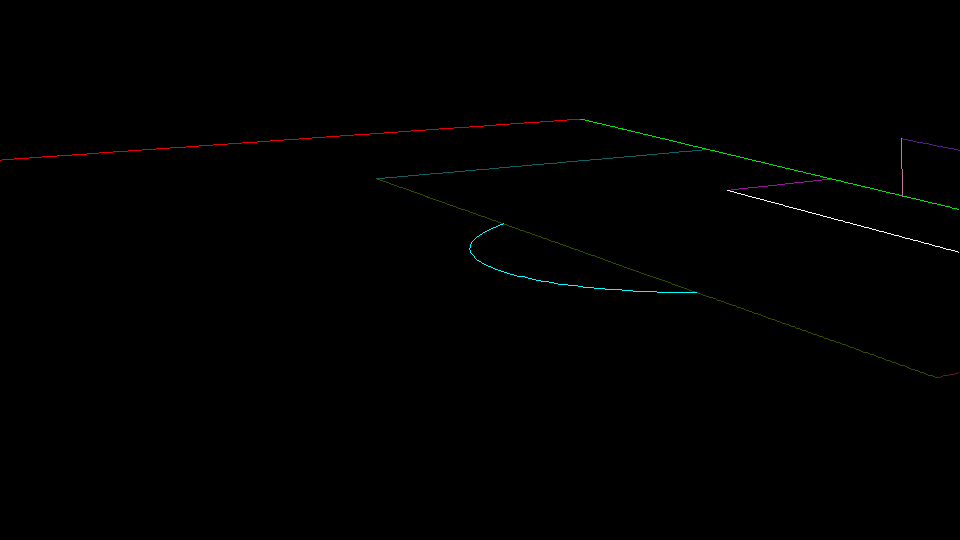

In [ ]:
black_img = np.zeros((540, 960, 3), dtype=np.uint8)
cam2.draw_colorful_pitch(black_img, SoccerPitch.palette)
rgb_model = cv2.cvtColor(black_img, cv2.COLOR_BGR2RGB)
pitch_model = Image.fromarray(rgb_model)
pitch_model

In [ ]:
def pan_tilt_roll_to_orientation(pan, tilt, roll):
    """
    Conversion from euler angles to orientation matrix.
    :param pan:
    :param tilt:
    :param roll:
    :return: orientation matrix
    """
    Rpan = np.array([
        [np.cos(pan), -np.sin(pan), 0],
        [np.sin(pan), np.cos(pan), 0],
        [0, 0, 1]])
    Rroll = np.array([
        [np.cos(roll), -np.sin(roll), 0],
        [np.sin(roll), np.cos(roll), 0],
        [0, 0, 1]])
    Rtilt = np.array([
        [1, 0, 0],
        [0, np.cos(tilt), -np.sin(tilt)],
        [0, np.sin(tilt), np.cos(tilt)]])
    rotMat = np.dot(Rpan, np.dot(Rtilt, Rroll))
    return rotMat

In [ ]:
def build_projection_matrix(params):
    fx = params['x_focal_length']
    fy = params['y_focal_length']
    cx, cy = params['principal_point']
    pan = np.radians(params['pan_degrees'])
    tilt = np.radians(params['tilt_degrees'])
    roll = np.radians(params['roll_degrees'])
    C = np.array(params['position_meters'])

    K = np.array([
        [fx,  0, cx],
        [ 0, fy, cy],
        [ 0,  0,  1]
    ])

    R_matrix = pan_tilt_roll_to_orientation(pan, tilt, roll).T
    t = -R_matrix @ C.reshape((3, 1))
    Rt = np.hstack((R_matrix, t))

    P = K @ Rt
    return P

P2 = build_projection_matrix(cam2.to_json_parameters())
print(P2)

[[ 1.85032268e+03  3.61166567e+02  4.28333407e+02 -3.30717618e+04]
 [-2.89381001e+01  9.93379866e+01  1.69321498e+03  1.55082193e+04]
 [ 6.34973422e-01 -6.47457107e-01  4.21435699e-01  3.37962405e+01]]


In [ ]:
image = cv2.imread("../images/0.png")
image = cv2.resize(image, (960, 540))
rgbimage = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

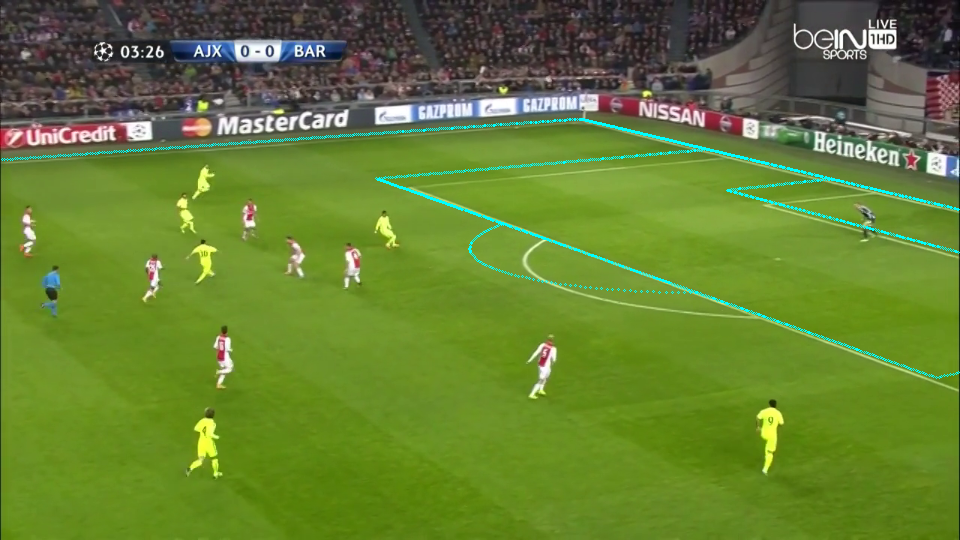

In [ ]:
def draw_pitch_projection_matrix(image, projection_matrix):
    """
    Draws points along the soccer pitch using a full 3x4 camera projection matrix M (P = K[R|t]).
    This function assumes that the pitch lies on the plane z=0 in world coordinates.

    :param image: the image to draw on
    :param projection_matrix: 3x4 camera projection matrix
    :return: modified image
    """
    field = SoccerPitch()
    polylines = field.sample_field_points()

    for line in polylines.values():
        for point in line:
            # We assume the pitch is at z = 0, so use only x, y
            if point[2] == 0.:
                X = np.array([point[0], point[1], 0., 1.])  # homogeneous 3D point with z = 0
                projected = projection_matrix @ X
                if projected[2] == 0.:
                    continue
                projected /= projected[2]
                x_img, y_img = projected[0], projected[1]

                # Make sure it's in bounds
                if 0 <= x_img < image.shape[1] and 0 <= y_img < image.shape[0]:
                    cv2.circle(image, (int(x_img), int(y_img)), 1, (0, 255, 255), 1)

    return image


cv_image = draw_pitch_projection_matrix(rgbimage, P2)
homography_pil = Image.fromarray(cv_image)
homography_pil

In [ ]:
img1 = cv2.imread("../images/0_0.png")
img1 = cv2.resize(img1, (960, 540))
img2 = cv2.imread("../images/0.png")
img2 = cv2.resize(img2, (960, 540))

### Pose estimation model

In [ ]:
from torchvision import models
import torch

# pose detection model
model = models.detection.keypointrcnn_resnet50_fpn(pretrained=True)
model.eval()

In [ ]:
def get_keypoints(img):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_tensor = torch.tensor(img_rgb).permute(2, 0, 1).unsqueeze(0).float() / 255.0

    with torch.no_grad():
        output = model(img_tensor)

    keypoints = []
    for i in range(len(output[0]['keypoints'])):
        keypoints.append(output[0]['keypoints'][i].cpu().numpy())  # List of keypoints for all people

    return keypoints

# Get keypoints for all 3 images
keypoints1 = get_keypoints(img1)
keypoints2 = get_keypoints(img2)

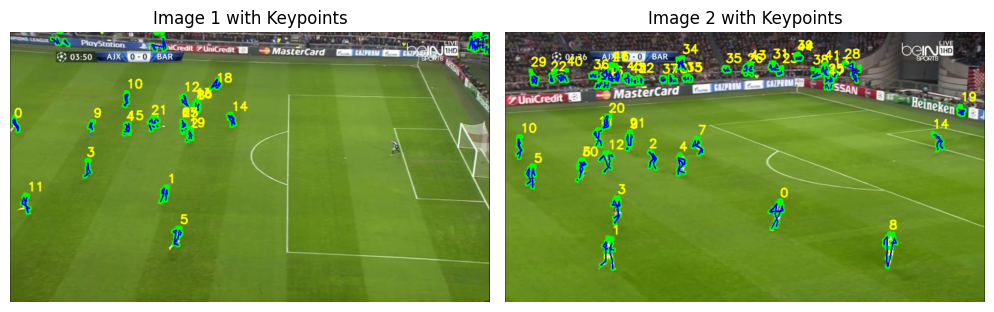

In [ ]:
def visualize_keypoints(img, keypoints_list, skeleton, player_numbers=None):
    img_copy = img.copy()

    for i, keypoints in enumerate(keypoints_list):
        # Draw keypoints
        for point in keypoints:
            if not np.any(np.isnan(point)):
                cv2.circle(img_copy, (int(point[0]), int(point[1])), 5, (0, 255, 0), -1)

        # Draw skeleton
        for joint1, joint2 in skeleton:
            if not np.any(np.isnan(keypoints[joint1])) and not np.any(np.isnan(keypoints[joint2])):
                point1 = keypoints[joint1]
                point2 = keypoints[joint2]
                cv2.line(img_copy, (int(point1[0]), int(point1[1])), (int(point2[0]), int(point2[1])), (255, 0, 0), 2)

        head = keypoints[0]  # assuming keypoint[0] is the head/nose
        if not np.any(np.isnan(head)):
            cv2.putText(img_copy, str(i), (int(head[0]), int(head[1]) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2, cv2.LINE_AA)

    return img_copy


skeleton = [
    (5, 7), (7, 9),   # Right arm
    (6, 8), (8, 10),  # Left arm
    (5, 11), (6, 12), # Torso sides
    (11, 13), (13, 15), # Right leg
    (12, 14), (14, 16)  # Left leg
]

img1_with_keypoints = visualize_keypoints(img1, keypoints1, skeleton)
img2_with_keypoints = visualize_keypoints(img2, keypoints2, skeleton)

plt.figure(figsize=(15, 15))

# Plot for img1
plt.subplot(131)
plt.imshow(cv2.cvtColor(img1_with_keypoints, cv2.COLOR_BGR2RGB))
plt.title('Image 1 with Keypoints')
plt.axis('off')

# Plot for img2
plt.subplot(132)
plt.imshow(cv2.cvtColor(img2_with_keypoints, cv2.COLOR_BGR2RGB))
plt.title('Image 2 with Keypoints')
plt.axis('off')

plt.tight_layout()
plt.show()


Manually match players. During a game, we would be tracking players from the beginning to easily find correspondences.

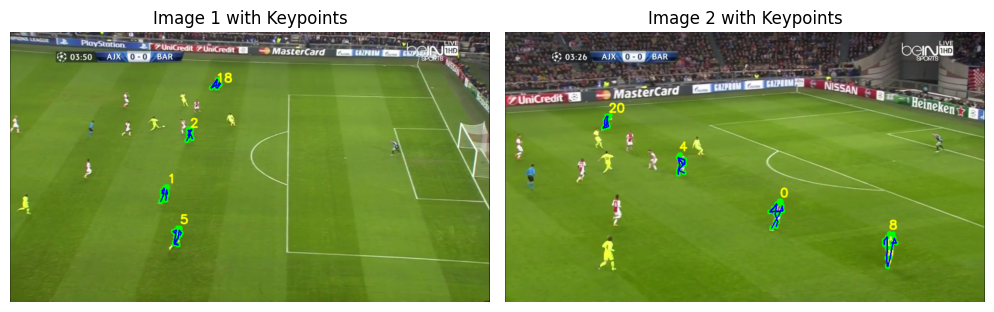

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def visualize_keypoints(img, keypoints_list, skeleton, players):
    img_copy = img.copy()  # Create a copy of the image
    updated_keypoints_list = []  # Initialize a list to store the processed keypoints

    for i, keypoints in enumerate(keypoints_list):
        if i in players:
            # Draw keypoints
            for point in keypoints:
                if not np.any(np.isnan(point)):
                    updated_keypoints_list.append((int(point[0]), int(point[1])))  # Append each keypoint
                    cv2.circle(img_copy, (int(point[0]), int(point[1])), 5, (0, 255, 0), -1)

            # Draw skeleton
            for joint1, joint2 in skeleton:
                if not np.any(np.isnan(keypoints[joint1])) and not np.any(np.isnan(keypoints[joint2])):
                    point1 = keypoints[joint1]
                    point2 = keypoints[joint2]
                    cv2.line(img_copy, (int(point1[0]), int(point1[1])), (int(point2[0]), int(point2[1])), (255, 0, 0), 2)

            # Draw player index near the head
            head = keypoints[0]  # Assuming keypoint[0] is the head/nose
            if not np.any(np.isnan(head)):
                cv2.putText(img_copy, str(i), (int(head[0]), int(head[1]) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2, cv2.LINE_AA)

    return img_copy, updated_keypoints_list


# Skeleton connections (you can customize this depending on your dataset)
skeleton = [
    (5, 7), (7, 9),   # Right arm
    (6, 8), (8, 10),  # Left arm
    (5, 11), (6, 12), # Torso sides
    (11, 13), (13, 15), # Right leg
    (12, 14), (14, 16)  # Left leg
]

# List of players (indices referring to players in the keypoints list)
# players1 = [14, 2, 5, 1, 18]
# players2 = [7, 4, 8, 0, 20]
players1 = [1, 5, 18, 2]
players2 = [0, 8, 20, 4]

# Visualizing keypoints on both images
img1_with_keypoints, updated_keypoints1 = visualize_keypoints(img1, keypoints1, skeleton, players1)
img2_with_keypoints, updated_keypoints2 = visualize_keypoints(img2, keypoints2, skeleton, players2)

# Plot the images
plt.figure(figsize=(15, 15))

# Plot for img1
plt.subplot(131)
plt.imshow(cv2.cvtColor(img1_with_keypoints, cv2.COLOR_BGR2RGB))
plt.title('Image 1 with Keypoints')
plt.axis('off')

# Plot for img2
plt.subplot(132)
plt.imshow(cv2.cvtColor(img2_with_keypoints, cv2.COLOR_BGR2RGB))
plt.title('Image 2 with Keypoints')
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
print(updated_keypoints1)
print(updated_keypoints2)

[(315, 312), (315, 311), (314, 310), (311, 310), (313, 310), (308, 313), (313, 316), (304, 318), (314, 322), (304, 324), (314, 325), (307, 325), (311, 325), (304, 332), (312, 330), (301, 339), (311, 337), (360, 201), (361, 200), (358, 197), (358, 194), (361, 195), (356, 197), (363, 196), (359, 206), (356, 206), (358, 212), (357, 211), (357, 198), (358, 198), (362, 208), (357, 210), (364, 214), (353, 218), (340, 393), (339, 392), (339, 392), (335, 392), (339, 393), (332, 396), (338, 397), (326, 399), (342, 402), (330, 402), (340, 406), (330, 411), (336, 411), (328, 421), (328, 424), (335, 425), (336, 426), (443, 168), (443, 168), (442, 167), (438, 166), (442, 165), (436, 168), (442, 168), (447, 175), (447, 174), (445, 183), (447, 180), (439, 175), (449, 185), (443, 180), (443, 178), (443, 188), (443, 186), (412, 111), (418, 96), (417, 96), (419, 96), (419, 95), (419, 100), (414, 96), (420, 106), (402, 113), (406, 110), (409, 108), (417, 104), (413, 103), (418, 108), (411, 108), (414, 11

In [ ]:
points_3d = []

num_keypoints = 17
num_persons = len(updated_keypoints1) // num_keypoints

for i in range(num_persons):
    kp1 = updated_keypoints1[i * num_keypoints:(i + 1) * num_keypoints]
    kp2 = updated_keypoints2[i * num_keypoints:(i + 1) * num_keypoints]

    for (x1, y1), (x2, y2) in zip(kp1, kp2):
        p1 = np.array([[x1], [y1]], dtype=np.float64)
        p2 = np.array([[x2], [y2]], dtype=np.float64)

        point_4d = cv2.triangulatePoints(P1, P2, p1, p2)  # shape: (4, 1)
        point_3d = (point_4d[:3] / point_4d[3]).flatten()  # shape: (3,)
        points_3d.append(point_3d)

points_3d = np.array(points_3d)  # shape: (num_persons * 17, 3)
print("Triangulated 3D Points:", len(points_3d))
print(points_3d)


Triangulated 3D Points: 68
[[ 27.09600708  15.28172828  -2.28576934]
 [ 27.10335524  15.33852627  -2.34901734]
 [ 27.06444215  15.30327277  -2.36303411]
 [ 26.96948046  15.44646561  -2.4031587 ]
 [ 27.04977204  15.48506177  -2.40069782]
 [ 26.84756565  15.39658062  -2.26872302]
 [ 27.04886404  15.55245326  -2.19520045]
 [ 26.6803988   15.30061655  -2.03081006]
 [ 27.07190006  15.48715666  -1.92242036]
 [ 26.62989442  14.96575198  -1.7047055 ]
 [ 26.92682953  14.29081129  -1.44072991]
 [ 26.77597659  15.2240457   -1.70377201]
 [ 26.93825382  15.32305274  -1.72773796]
 [ 26.69754466  15.57073258  -1.49475402]
 [ 26.91215817  14.7836189   -1.27427802]
 [ 26.57879374  15.60814832  -1.24998215]
 [ 26.8281409   14.44798908  -0.8510188 ]
 [ 27.5649922    0.09650194  -1.72031865]
 [ 27.60939935   0.06266267  -1.75033724]
 [ 27.50967665   0.21100014  -1.87305907]
 [ 27.53396551   0.28786713  -1.98632171]
 [ 27.62065821  -0.15203955  -1.82669725]
 [ 27.43067474   0.13210126  -1.78612989]
 [ 27.6

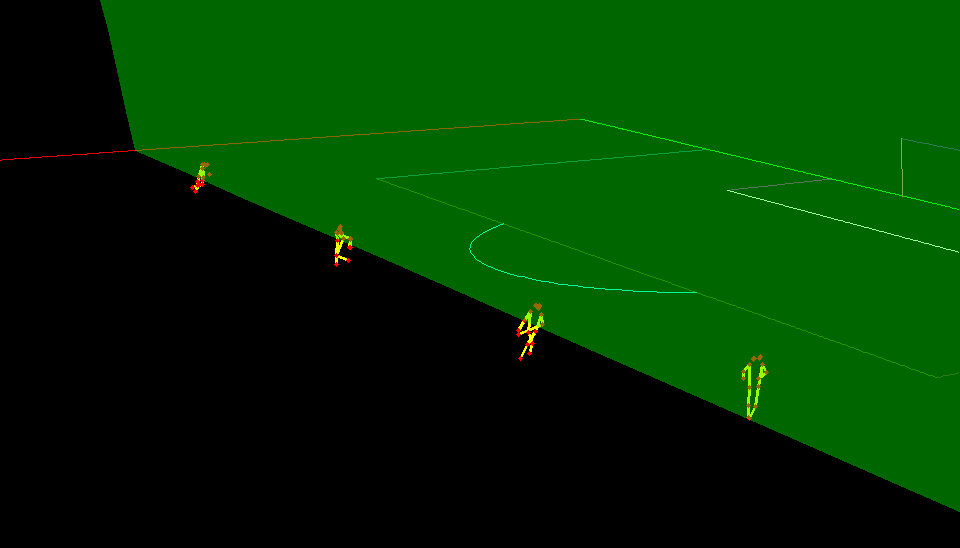

In [ ]:
def draw_colorful_pitch(image, palette, cam, points_3d, draw_skeleton=True):
    """
    Draws all pitch lines and player skeletons on the image.

    :param image: image to draw on
    :param palette: dict mapping pitch elements to BGR colors
    :param cam: Camera object used to project 3D points
    :param points_3d: flat list of 3D points for all players (multiple of 17)
    :param draw_skeleton: whether to draw skeletons or just player points
    :return: image with pitch and player skeletons
    """
    field = SoccerPitch()
    polylines = field.sample_field_points()

    # Draw pitch lines
    for key, line in polylines.items():
        if key not in palette:
            print(f"Can't draw {key}")
            continue
        prev_point = cam.project_point(line[0])
        for point in line[1:]:
            projected = cam.project_point(point)
            if projected[2] == 0.:
                continue
            projected /= projected[2]
            if 0 < projected[0] < cam.image_width and 0 < projected[1] < cam.image_height:
                cv2.line(image, (int(prev_point[0]), int(prev_point[1])),
                         (int(projected[0]), int(projected[1])),
                         palette[key][::-1], 1)
            prev_point = projected

    # Draw skeletons or just player points
    skeleton = [
        (5, 7), (7, 9),       # Right arm
        (6, 8), (8, 10),      # Left arm
        (5, 11), (6, 12),     # Torso sides
        (11, 13), (13, 15),   # Right leg
        (12, 14), (14, 16)    # Left leg
    ]

    num_players = len(points_3d) // 17
    for i in range(num_players):
        joints = points_3d[i * 17: (i + 1) * 17]
        projected_joints = []
        for point in joints:
            projected = cam.project_point(point)
            if projected[2] != 0:
                projected /= projected[2]
                projected_joints.append((int(projected[0]), int(projected[1])))
            else:
                projected_joints.append(None)

        if draw_skeleton:
            for a, b in skeleton:
                if projected_joints[a] is not None and projected_joints[b] is not None:
                    cv2.line(image, projected_joints[a], projected_joints[b], (0, 255, 255), 2)  # Yellow lines

        for pt in projected_joints:
            if pt is not None:
                cv2.circle(image, pt, radius=2, color=(0, 0, 255), thickness=-1)  # red joints

       # === Draw YZ Plane at x = 30 ===
    x_const = 30
    y_range = np.linspace(-34, 34, 10)   # Player height, 0 to 2.5m
    z_range = np.linspace(0, -34, 20)  # Field width/depth

    pane_color = (0, 255, 0)             # Green in BGR
    alpha = 0.4                          # Transparency level

    overlay = image.copy()

    for i in range(len(y_range) - 1):
        for j in range(len(z_range) - 1):
            # Define 4 corners of the quad (Y-Z grid cell at x = 30)
            pts_3d = [
                np.array([x_const, y_range[i], z_range[j]]),
                np.array([x_const, y_range[i + 1], z_range[j]]),
                np.array([x_const, y_range[i + 1], z_range[j + 1]]),
                np.array([x_const, y_range[i], z_range[j + 1]])
            ]

            pts_2d = []
            for pt in pts_3d:
                proj = cam.project_point(pt)
                if proj[2] == 0:
                    break
                proj /= proj[2]
                pts_2d.append((int(proj[0]), int(proj[1])))

            if len(pts_2d) == 4:
                cv2.fillConvexPoly(overlay, np.array(pts_2d, dtype=np.int32), pane_color)

    # Blend overlay onto image
    cv2.addWeighted(overlay, alpha, image, 1 - alpha, 0, image)

    return image


black_img = np.zeros((548, 960, 3), dtype=np.uint8)
draw_colorful_pitch(black_img, SoccerPitch.palette, cam2, points_3d)

rgb_model = cv2.cvtColor(black_img, cv2.COLOR_BGR2RGB)
pitch_model = Image.fromarray(rgb_model)
pitch_model

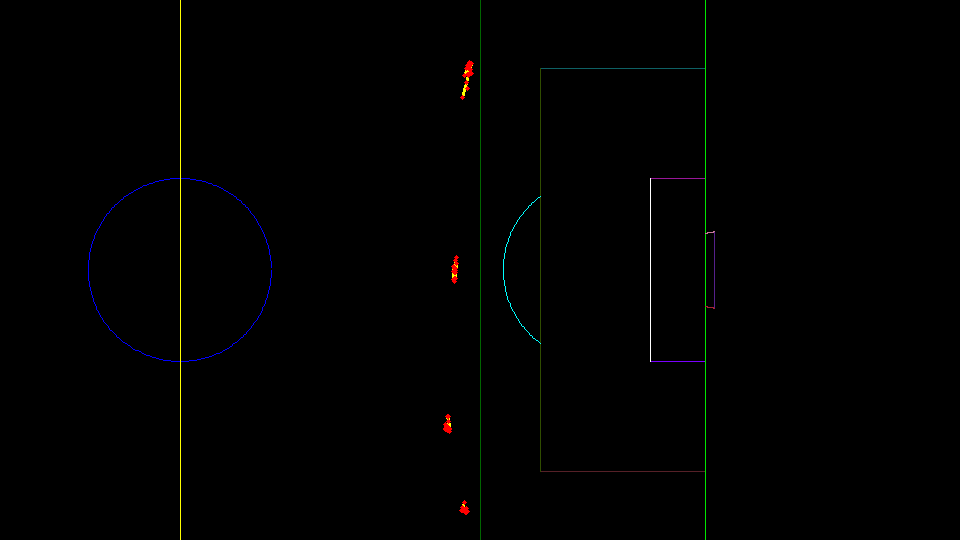

In [ ]:
def draw_colorful_pitch(image, palette, cam, points_3d, draw_skeleton=True):
    """
    Draws all pitch lines and player skeletons on the image.

    :param image: image to draw on
    :param palette: dict mapping pitch elements to BGR colors
    :param cam: Camera object used to project 3D points
    :param points_3d: flat list of 3D points for all players (multiple of 17)
    :param draw_skeleton: whether to draw skeletons or just player points
    :return: image with pitch and player skeletons
    """
    field = SoccerPitch()
    polylines = field.sample_field_points()

    # Draw pitch lines
    for key, line in polylines.items():
        if key not in palette:
            print(f"Can't draw {key}")
            continue
        prev_point = cam.project_point(line[0])
        for point in line[1:]:
            projected = cam.project_point(point)
            if projected[2] == 0.:
                continue
            projected /= projected[2]
            if 0 < projected[0] < cam.image_width and 0 < projected[1] < cam.image_height:
                cv2.line(image, (int(prev_point[0]), int(prev_point[1])),
                         (int(projected[0]), int(projected[1])),
                         palette[key][::-1], 1)
            prev_point = projected

    # Draw skeletons or just player points
    skeleton = [
        (5, 7), (7, 9),       # Right arm
        (6, 8), (8, 10),      # Left arm
        (5, 11), (6, 12),     # Torso sides
        (11, 13), (13, 15),   # Right leg
        (12, 14), (14, 16)    # Left leg
    ]

    num_players = len(points_3d) // 17
    for i in range(num_players):
        joints = points_3d[i * 17: (i + 1) * 17]
        projected_joints = []
        for point in joints:
            projected = cam.project_point(point)
            if projected[2] != 0:
                projected /= projected[2]
                projected_joints.append((int(projected[0]), int(projected[1])))
            else:
                projected_joints.append(None)

        if draw_skeleton:
            for a, b in skeleton:
                if projected_joints[a] is not None and projected_joints[b] is not None:
                    cv2.line(image, projected_joints[a], projected_joints[b], (0, 255, 255), 2)  # Yellow lines

        for pt in projected_joints:
            if pt is not None:
                cv2.circle(image, pt, radius=2, color=(0, 0, 255), thickness=-1)  # red joints
    x_const = 30
    y_range = np.linspace(-34, 34, 10)   # Player height, 0 to 2.5m
    z_range = np.linspace(0, -34, 20)  # Field width/depth
    pane_color = (0, 255, 0)             # Green in BGR
    alpha = 0.4                          # Transparency level

    overlay = image.copy()

    for i in range(len(y_range) - 1):
        for j in range(len(z_range) - 1):
            # Define 4 corners of the quad (Y-Z grid cell at x = 30)
            pts_3d = [
                np.array([x_const, y_range[i], z_range[j]]),
                np.array([x_const, y_range[i + 1], z_range[j]]),
                np.array([x_const, y_range[i + 1], z_range[j + 1]]),
                np.array([x_const, y_range[i], z_range[j + 1]])
            ]

            pts_2d = []
            for pt in pts_3d:
                proj = cam.project_point(pt)
                if proj[2] == 0:
                    break
                proj /= proj[2]
                pts_2d.append((int(proj[0]), int(proj[1])))

            if len(pts_2d) == 4:
                cv2.fillConvexPoly(overlay, np.array(pts_2d, dtype=np.int32), pane_color)

    # Blend overlay onto image
    cv2.addWeighted(overlay, alpha, image, 1 - alpha, 0, image)
    return image


camera = Camera(960, 540)
camera.xfocal_length = 600
camera.yfocal_length = 600
camera.position = [30, 0, -60]
black_img = np.zeros((540, 960, 3), dtype=np.uint8)
draw_colorful_pitch(black_img, SoccerPitch.palette, camera, points_3d)

rgb_model = cv2.cvtColor(black_img, cv2.COLOR_BGR2RGB)
pitch_model = Image.fromarray(rgb_model)
pitch_model

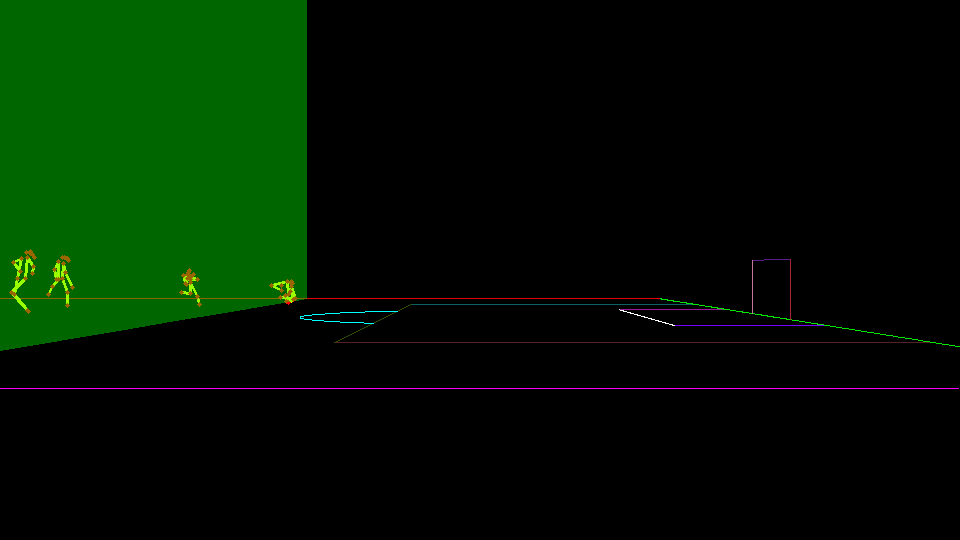

In [ ]:
def draw_colorful_pitch(image, palette, cam, points_3d, draw_skeleton=True):
    """
    Draws all pitch lines and player skeletons on the image.

    :param image: image to draw on
    :param palette: dict mapping pitch elements to BGR colors
    :param cam: Camera object used to project 3D points
    :param points_3d: flat list of 3D points for all players (multiple of 17)
    :param draw_skeleton: whether to draw skeletons or just player points
    :return: image with pitch and player skeletons
    """
    field = SoccerPitch()
    polylines = field.sample_field_points()

    # Draw pitch lines
    for key, line in polylines.items():
        if key not in palette:
            print(f"Can't draw {key}")
            continue
        prev_point = cam.project_point(line[0])
        for point in line[1:]:
            projected = cam.project_point(point)
            if projected[2] == 0.:
                continue
            projected /= projected[2]
            if 0 < projected[0] < cam.image_width and 0 < projected[1] < cam.image_height:
                cv2.line(image, (int(prev_point[0]), int(prev_point[1])),
                         (int(projected[0]), int(projected[1])),
                         palette[key][::-1], 1)
            prev_point = projected

    # Draw skeletons or just player points
    skeleton = [
        (5, 7), (7, 9),       # Right arm
        (6, 8), (8, 10),      # Left arm
        (5, 11), (6, 12),     # Torso sides
        (11, 13), (13, 15),   # Right leg
        (12, 14), (14, 16)    # Left leg
    ]

    num_players = len(points_3d) // 17
    for i in range(num_players):
        joints = points_3d[i * 17: (i + 1) * 17]
        projected_joints = []
        for point in joints:
            projected = cam.project_point(point)
            if projected[2] != 0:
                projected /= projected[2]
                projected_joints.append((int(projected[0]), int(projected[1])))
            else:
                projected_joints.append(None)

        if draw_skeleton:
            for a, b in skeleton:
                if projected_joints[a] is not None and projected_joints[b] is not None:
                    cv2.line(image, projected_joints[a], projected_joints[b], (0, 255, 255), 2)  # Yellow lines

        for pt in projected_joints:
            if pt is not None:
                cv2.circle(image, pt, radius=2, color=(0, 0, 255), thickness=-1)  # red joints
    x_const = 28
    y_range = np.linspace(-34, 34, 10)   # Player height, 0 to 2.5m
    z_range = np.linspace(0, -34, 20)  # Field width/depth
    pane_color = (0, 255, 0)             # Green in BGR
    alpha = 0.4                          # Transparency level

    overlay = image.copy()

    for i in range(len(y_range) - 1):
        for j in range(len(z_range) - 1):
            # Define 4 corners of the quad (Y-Z grid cell at x = 30)
            pts_3d = [
                np.array([x_const, y_range[i], z_range[j]]),
                np.array([x_const, y_range[i + 1], z_range[j]]),
                np.array([x_const, y_range[i + 1], z_range[j + 1]]),
                np.array([x_const, y_range[i], z_range[j + 1]])
            ]

            pts_2d = []
            for pt in pts_3d:
                proj = cam.project_point(pt)
                if proj[2] == 0:
                    break
                proj /= proj[2]
                pts_2d.append((int(proj[0]), int(proj[1])))

            if len(pts_2d) == 4:
                cv2.fillConvexPoly(overlay, np.array(pts_2d, dtype=np.int32), pane_color)

    # Blend overlay onto image
    cv2.addWeighted(overlay, alpha, image, 1 - alpha, 0, image)
    return image


camera = Camera(960, 540)
camera.xfocal_length = 1300
camera.yfocal_length = 1300
camera.position = [40, 56, -2]
camera.rotation = pan_tilt_roll_to_orientation(0, np.radians(90), 0).T
black_img = np.zeros((540, 960, 3), dtype=np.uint8)
draw_colorful_pitch(black_img, SoccerPitch.palette, camera, points_3d)

rgb_model = cv2.cvtColor(black_img, cv2.COLOR_BGR2RGB)
pitch_model = Image.fromarray(rgb_model)
pitch_model

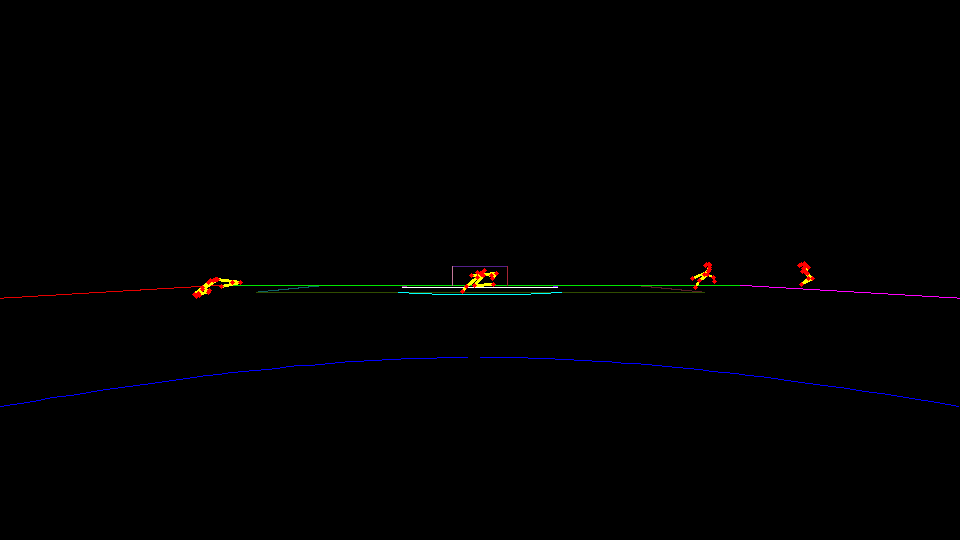

In [ ]:
def draw_colorful_pitch(image, palette, cam, points_3d, draw_skeleton=True):
    """
    Draws all pitch lines and player skeletons on the image.

    :param image: image to draw on
    :param palette: dict mapping pitch elements to BGR colors
    :param cam: Camera object used to project 3D points
    :param points_3d: flat list of 3D points for all players (multiple of 17)
    :param draw_skeleton: whether to draw skeletons or just player points
    :return: image with pitch and player skeletons
    """
    field = SoccerPitch()
    polylines = field.sample_field_points()

    # Draw pitch lines
    for key, line in polylines.items():
        if key not in palette:
            print(f"Can't draw {key}")
            continue
        prev_point = cam.project_point(line[0])
        for point in line[1:]:
            projected = cam.project_point(point)
            if projected[2] == 0.:
                continue
            projected /= projected[2]
            if 0 < projected[0] < cam.image_width and 0 < projected[1] < cam.image_height:
                cv2.line(image, (int(prev_point[0]), int(prev_point[1])),
                         (int(projected[0]), int(projected[1])),
                         palette[key][::-1], 1)
            prev_point = projected

    # Draw skeletons or just player points
    skeleton = [
        (5, 7), (7, 9),       # Right arm
        (6, 8), (8, 10),      # Left arm
        (5, 11), (6, 12),     # Torso sides
        (11, 13), (13, 15),   # Right leg
        (12, 14), (14, 16)    # Left leg
    ]

    num_players = len(points_3d) // 17
    for i in range(num_players):
        joints = points_3d[i * 17: (i + 1) * 17]
        projected_joints = []
        for point in joints:
            projected = cam.project_point(point)
            if projected[2] != 0:
                projected /= projected[2]
                projected_joints.append((int(projected[0]), int(projected[1])))
            else:
                projected_joints.append(None)

        if draw_skeleton:
            for a, b in skeleton:
                if projected_joints[a] is not None and projected_joints[b] is not None:
                    cv2.line(image, projected_joints[a], projected_joints[b], (0, 255, 255), 2)  # Yellow lines

        for pt in projected_joints:
            if pt is not None:
                cv2.circle(image, pt, radius=2, color=(0, 0, 255), thickness=-1)  # red joints

    return image


camera = Camera(960, 540)
camera.xfocal_length = 400
camera.yfocal_length = 400
camera.position = [0, 0, -2]
camera.rotation = pan_tilt_roll_to_orientation(np.radians(90), np.radians(90), 0).T
black_img = np.zeros((540, 960, 3), dtype=np.uint8)
draw_colorful_pitch(black_img, SoccerPitch.palette, camera, points_3d)

rgb_model = cv2.cvtColor(black_img, cv2.COLOR_BGR2RGB)
pitch_model = Image.fromarray(rgb_model)
pitch_model